In [20]:
#Import the libraries
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, DotProduct, ConstantKernel as C
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt

In [21]:
# Load the data
tensile_df =  pd.read_excel("../Tensile_Properties_Data.xlsx", header=0, skiprows=1)
tensile_df

,Reference,Material,Material Group,C (wt.%),Si (wt.%),Mn (wt.%),P (wt.%),S (wt.%),Ni (wt.%),Cr (wt.%),...,Width (mm),Aspect Ratio (L/W),Aspect Ratio (R/W),Aspect Ratio (T/W),Test Temperature (C),Strain Rate (1/s),Yield Strength (MPa),Ultimate Tensile Strength (MPa),Uniform Elongation (%),Total Elongation (%)
0,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,1.2,4.166700,1.1667,0.625000,23.0,0.001000,274.0,789.0,67.00,76.00
1,1,SS304L,"NSM, Rector Internals",0.02,0.45,1.30,NaN,NaN,8.02,18.30,...,0.8,4.437500,0.3750,0.500000,23.0,0.001000,272.0,781.0,69.00,80.00
2,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,1.2,4.166700,1.1667,0.416667,23.0,0.001000,710.0,767.0,7.90,14.80
3,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,607.0,760.0,10.80,23.10
4,1,FeCrAl,"NSM, Fuel Cladding",NaN,0.13,NaN,NaN,NaN,NaN,13.10,...,0.8,3.187500,0.3750,0.500000,23.0,0.001000,725.0,782.0,6.60,18.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,114.0,0.222807,NaN,0.114035,760.0,0.000067,214.0,572.0,59.35,67.66
1469,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.000067,207.0,494.0,38.80,47.80
1470,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,NaN,NaN,NaN,NaN,760.0,0.003667,101.0,352.0,31.22,47.25
1471,27,SS316,SS316,0.065,0.31,1.75,0.025,0.0175,13.50,17.00,...,25.0,2.032000,NaN,0.000000,760.0,0.000067,177.0,497.0,40.40,46.50


In [22]:
# Check the data information for each column.
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 56 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Reference                        1473 non-null   int64  
 1   Material                         1473 non-null   object 
 2   Material Group                   1473 non-null   object 
 3   C (wt.%)                         1210 non-null   object 
 4   Si (wt.%)                        1174 non-null   float64
 5   Mn (wt.%)                        1179 non-null   float64
 6   P (wt.%)                         1157 non-null   float64
 7   S (wt.%)                         965 non-null    float64
 8   Ni (wt.%)                        1387 non-null   float64
 9   Cr (wt.%)                        1404 non-null   float64
 10  Mo (wt.%)                        1331 non-null   float64
 11  Al (wt.%)                        484 non-null    float64
 12  N (wt.%)            

In [23]:
# Select the composition columns
compostion_cols = tensile_df.columns[3:29]
compostion_cols

Index(['C (wt.%)', 'Si (wt.%)', 'Mn (wt.%)', 'P (wt.%)', 'S (wt.%)',
       'Ni (wt.%)', 'Cr (wt.%)', 'Mo (wt.%)', 'Al (wt.%)', 'N (wt.%)',
       'Ti (wt.%)', 'Fe (wt.%)', 'Nb (wt.%)', 'B (wt.%)', 'Cu (wt.%)',
       'V (wt.%)', 'Mg (wt.%)', 'Y (wt.%)', 'Zr (wt.%)', 'Zn (wt.%)',
       'W (wt.%)', 'Sn (wt.%)', 'Co (wt.%)', 'O (wt.,%)', 'Ta (wt.%)',
       'H (wt.%)'],
      dtype='object')

In [24]:
# Fill the nan values with 0 for the comospition columns
tensile_df[compostion_cols]  = tensile_df[compostion_cols].fillna(0)
tensile_df['Irradiation Dose (mdpa)']  = tensile_df['Irradiation Dose (mdpa)'].fillna(0)
tensile_df['Irradiation Temperature (C)']  = tensile_df['Irradiation Temperature (C)'].fillna(0)

In [25]:
# Select SS316 stainless steel and sub-sized data
tensile_df  = tensile_df[(tensile_df['Material Group'].str.contains('ss316', case=False))& (tensile_df['Specimen Size'] == 'Sub-sized')]

In [26]:
# check if these columns have noisy data.
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.018 0.055 0.03 0.061 0.05 0.04 0.058]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[68.052 63.537800000000004 67.9 64.94000000000001 0 58.8682
 66.80699999999999 63.4728]


In [27]:
# Clean the data
tensile_df = tensile_df[~tensile_df['Zr (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['C (wt.%)'].isin(['<','ppm','bal'])]
tensile_df = tensile_df[~tensile_df['Fe (wt.%)'].isin(['<','ppm','bal'])]


In [28]:
# Check the data again, make sure  the data is cleaned
print('unique values for Zr (wt.%) column:' + str(tensile_df['Zr (wt.%)'].unique()))
print(100*'_')
print('unique values for C (wt.%) column:' + str(tensile_df['C (wt.%)'].unique()))
print(100*'_')
print('unique values for Fe (wt.%) column:' + str(tensile_df['Fe (wt.%)'].unique()))

unique values for Zr (wt.%) column:[0]
____________________________________________________________________________________________________
unique values for C (wt.%) column:[0.018 0.055 0.03 0.061 0.05 0.04 0.058]
____________________________________________________________________________________________________
unique values for Fe (wt.%) column:[68.052 63.537800000000004 67.9 64.94000000000001 0 58.8682
 66.80699999999999 63.4728]


In [29]:
# convert all of the composition columns' data type to float
tensile_df[compostion_cols]  = tensile_df[compostion_cols].astype(float)

In [30]:
# Drop the columns that don't have  enough data records. 

tensile_df = tensile_df.drop(columns=[ 'Reference','Manufacturing','Cooling', 'Material', 'Treatment', 'Specimen Size Type',
                                       'Irradiation Time (h)', 'Fillet Radius (mm)', 'Specimen Size', 'Specimen Shape',
                                       'Post Treatment Temperature (C)','Post Treatment Time (h)','Microstructure', 'Aspect Ratio (R/W)', 'Uniform Elongation (%)',
                                       'Yield Strength (MPa)', 'Total Elongation (%)','Specimen Shape'
                                       ])


In [31]:
# remove nan values from the dataset
tensile_df = tensile_df.dropna()
tensile_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209 entries, 21 to 907
Data columns (total 39 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Material Group                   209 non-null    object 
 1   C (wt.%)                         209 non-null    float64
 2   Si (wt.%)                        209 non-null    float64
 3   Mn (wt.%)                        209 non-null    float64
 4   P (wt.%)                         209 non-null    float64
 5   S (wt.%)                         209 non-null    float64
 6   Ni (wt.%)                        209 non-null    float64
 7   Cr (wt.%)                        209 non-null    float64
 8   Mo (wt.%)                        209 non-null    float64
 9   Al (wt.%)                        209 non-null    float64
 10  N (wt.%)                         209 non-null    float64
 11  Ti (wt.%)                        209 non-null    float64
 12  Fe (wt.%)                 

In [32]:
# sort the dataframe by UTS values
tensile_df = tensile_df.sort_values(by='Ultimate Tensile Strength (MPa)').reset_index(drop=True)


In [33]:
# Select columns for modeling. 

input_features_df =  tensile_df.drop(columns=['Ultimate Tensile Strength (MPa)'])

In [34]:
# Encode the categorical columns 
input_features_df['Material Group'] = input_features_df['Material Group'].astype('category')
input_features_df['Material Group'] = input_features_df['Material Group'].cat.codes

input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].astype('category')
input_features_df['Treatment – Three Categories'] = input_features_df['Treatment – Three Categories'].cat.codes

In [35]:
# make sure input features are float data type
input_features_df = input_features_df.astype('float')

In [36]:
# define input features and input targets variables
features = input_features_df
targets = tensile_df['Ultimate Tensile Strength (MPa)']

In [37]:
# define the coverage
def coverage(y, yL, yH):
    return np.sum(100 / y.shape[0] * ((y>yL)&(y<yH)))

Run # 1 Fold # 1
Pearson CC: 0.9320041985168771
R2 score: 0.8673113953798909
RMSE: 55.97109625832224
MAE: 33.88570784341856
Coverage: 95.23809523809524
Median Interval Width: 234.0306992760729
Composite Metric: 0.7153539502084942


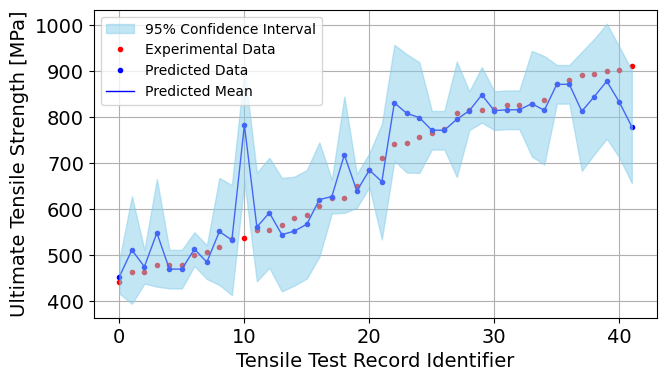

********************
Run # 1 Fold # 2
Pearson CC: 0.939546889157381
R2 score: 0.8767840037144896
RMSE: 41.57796371201968
MAE: 28.893708750019435
Coverage: 95.23809523809524
Median Interval Width: 255.6724197576641
Composite Metric: 0.7152635280062437


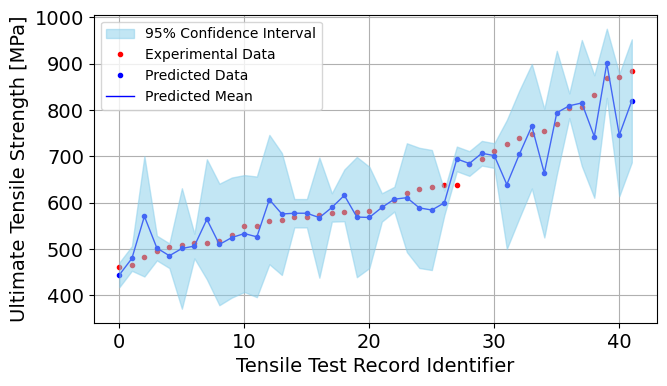

********************
Run # 1 Fold # 3
Pearson CC: 0.9190261918034235
R2 score: 0.8443509423083463
RMSE: 56.21524749360541
MAE: 33.19233705219056
Coverage: 95.23809523809524
Median Interval Width: 237.47601465799082
Composite Metric: 0.7153384521816237


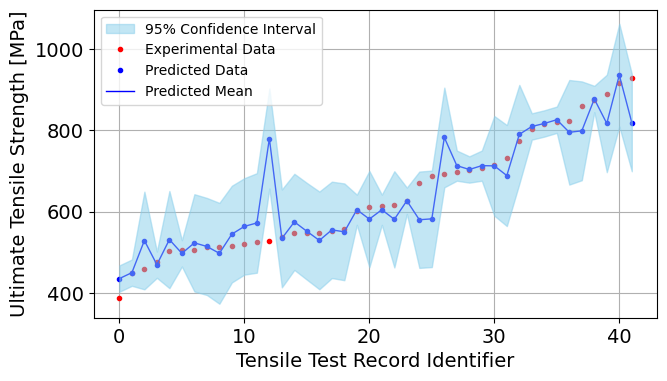

********************
Run # 1 Fold # 4
Pearson CC: 0.8826719824284756
R2 score: 0.7592305629502769
RMSE: 64.47910764310238
MAE: 39.4716638476176
Coverage: 80.95238095238095
Median Interval Width: 227.98334924638675
Composite Metric: 0.6082394284531146


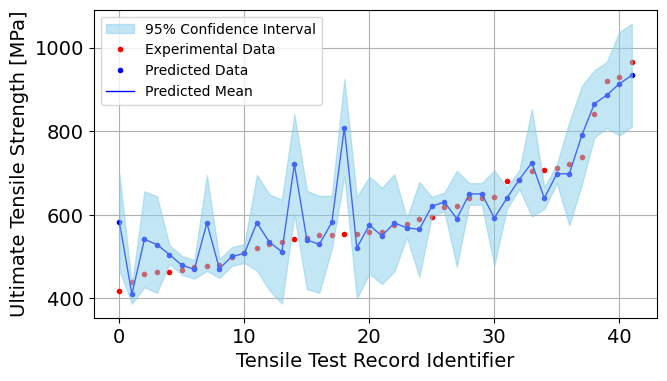

********************
Run # 1 Fold # 5
Pearson CC: 0.9519154159938609
R2 score: 0.8977046706008929
RMSE: 42.769726705786724
MAE: 27.77548854684253
Coverage: 97.5609756097561
Median Interval Width: 261.254788641867
Composite Metric: 0.7326642373321242


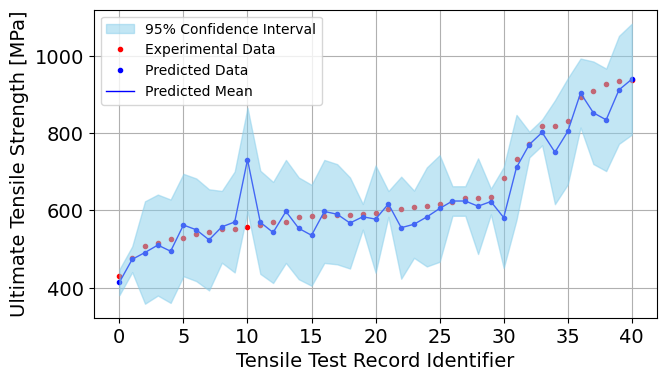

********************


In [38]:
# Evaluate multiple runs of the model
nruns = 1

nfolds = 5

PearsonCC = np.zeros((nruns, nfolds))
R2_score = np.zeros_like(PearsonCC)
RMSE = np.zeros_like(PearsonCC)
MAE = np.zeros_like(PearsonCC)
MAPE = np.zeros_like(PearsonCC)

test_coverage = np.zeros_like(PearsonCC)
upper_coverage = np.zeros_like(PearsonCC)
lower_coverage = np.zeros_like(PearsonCC)
mean_interval_width = np.zeros_like(PearsonCC)
median_interval_width = np.zeros_like(PearsonCC)
composite_metric = np.zeros_like(PearsonCC)

for j in range(nruns):

        kf = KFold(n_splits=nfolds, shuffle=True, random_state=123+j)

        kernel = C(1.0) * Matern(length_scale=1.0) + WhiteKernel(noise_level=1.0) + C(1.0) * DotProduct(sigma_0=1.0)

        for i, (tr, ts) in enumerate(kf.split(targets)):

            # Display the run number
            print('Run #', j+1, "Fold #", i+1)

            X_train, X_test = features.iloc[tr], features.iloc[ts]
            y_train, y_test = targets[tr], targets[ts]

            scale = MinMaxScaler()
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)

            model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=8, normalize_y=True)

            model.fit(X_train, y_train)

            mu_z, std_z = model.predict(X_test, return_std=True)
            y_pred_test = mu_z
            y_pred_unc_test = std_z

            PearsonCC[j, i] = pearsonr(y_test, y_pred_test)[0]
            R2_score[j, i] = r2_score(y_test, y_pred_test)
            RMSE[j, i] = sqrt(mean_squared_error(y_pred_test, y_test))
            MAE[j, i] = np.mean(abs(y_pred_test-y_test))

            df_test_low = y_pred_test - 2 * y_pred_unc_test
            df_test_median = y_pred_test
            df_test_high = y_pred_test + 2 * y_pred_unc_test

            test_coverage[j, i] = coverage(y_test, df_test_low, df_test_high)

            print(f'Pearson CC: {PearsonCC[j, i]}')
            print(f'R2 score: {R2_score[j, i]}')
            print(f'RMSE: {RMSE[j, i]}')
            print(f'MAE: {MAE[j, i]}')
            print(f'Coverage: {test_coverage[j, i]}')
            
            # Prediction interval width
            # Quantifies the average width of the prediction intervals. Smaller widths suggest more precise uncertainty estimates.

            median_interval_width[j, i] = np.median(df_test_high - df_test_low)
            print(f'Median Interval Width: {median_interval_width[j, i]}')

            # Composite metric that combines the coverage and the invers of interval width
            composite_metric[j, i] = 0.75*test_coverage[j, i]/100 + 0.25*(1/median_interval_width[j, i])
            print(f'Composite Metric: {composite_metric[j, i]}')

            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 4))
            iteration_list = [i for i in range(len(y_test))]
                        ## Uncertainty quantification plot
            y_pred = y_pred_test
            y_std = y_pred_unc_test
            ax[0].fill_between(iteration_list, y_pred - 2*y_std, y_pred + 2*y_std, alpha=0.5, color='skyblue', zorder=5, label='95% Confidence Interval')
            ax[0].plot(iteration_list, y_test, 'ro', markersize=3, label="Experimental Data")
            ax[0].plot(iteration_list, y_pred, 'bo', markersize=3, label="Predicted Data")
            ax[0].plot(iteration_list, y_pred, '-', linewidth=1, color="blue", label="Predicted Mean")
            ax[0].legend(fontsize=10, frameon=True, loc="upper left")
            ax[0].set_xlabel("Tensile Test Record Identifier", fontsize=14)
            ax[0].set_ylabel("Ultimate Tensile Strength [MPa]", fontsize=14)
            ax[0].tick_params(axis='both', which='major', labelsize=14)
            ax[0].grid(True, which='major', linestyle='-', linewidth='0.8')
            fig.delaxes(ax[1])
            plt.show()
            print(20*'*')